# Image Background Removal with U^2-Net and OpenVINO™

This notebook demonstrates background removal in images using U$^2$-Net and OpenVINO.

For more information about U$^2$-Net, including source code and test data, see the [GitHub page](https://github.com/xuebinqin/U-2-Net) and the research paper: [U^2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/pdf/2005.09007.pdf).

The PyTorch U$^2$-Net model is converted to OpenVINO IR format. The model source is available [here](https://github.com/xuebinqin/U-2-Net).

#### Table of content:
- [Preparation](#Preparation-Uparrow)
    - [Install requirements](#Install-requirements-Uparrow)
    - [Import the PyTorch Library and U$^2$-Net](#Import-the-PyTorch-Library-and-U2-Net-Uparrow)
    - [Settings](#Settings-Uparrow)
    - [Load the U$^2$-Net Model](#Load-the-U2-Net-Model-Uparrow)
- [Convert PyTorch U$^2$-Net model to OpenVINO IR](#Convert-PyTorch-U2-Net-model-to-OpenVINO-IR-Uparrow)
    - [Convert Pytorch model to OpenVINO IR Format](#Convert-Pytorch-model-to-OpenVINO-IR-Format-Uparrow)
- [Load and Pre-Process Input Image](#Load-and-Pre-Process-Input-Image-Uparrow)
- [Select inference device](#Select-inference-device-Uparrow)
- [Do Inference on OpenVINO IR Model](#Do-Inference-on-OpenVINO-IR-Model-Uparrow)
- [Visualize Results](#Visualize-Results-Uparrow)
    - [Add a Background Image](#Add-a-Background-Image-Uparrow)
- [References](#References-Uparrow)


## Preparation [$\Uparrow$](#Table-of-content:)

### Install requirements [$\Uparrow$](#Table-of-content:)


In [1]:
%pip install -q "openvino>=2023.1.0"
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu torch opencv-python matplotlib
%pip install -q gdown

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openvino-dev 2022.3.0 requires openvino==2022.3.0, but you have openvino 2023.1.0 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import the PyTorch Library and U$^2$-Net [$\Uparrow$](#Table-of-content:)


In [2]:
import os
import time
import sys
from collections import namedtuple
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
import torch
from IPython.display import HTML, FileLink, display

In [3]:
# Import local modules

utils_file_path = Path("../utils/notebook_utils.py")
notebook_directory_path = Path(".")

if not utils_file_path.exists():
    !git clone --depth 1 https://github.com/openvinotoolkit/openvino_notebooks.git
    utils_file_path = Path("./openvino_notebooks/notebooks/utils/notebook_utils.py")
    notebook_directory_path = Path("./openvino_notebooks/notebooks/205-vision-background-removal/")

sys.path.append(str(utils_file_path.parent))
sys.path.append(str(notebook_directory_path))

from notebook_utils import load_image
from model.u2net import U2NET, U2NETP

Cloning into 'openvino_notebooks'...
remote: Enumerating objects: 511, done.
remote: Counting objects: 100% (511/511), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 511 (delta 31), reused 284 (delta 17), pack-reused 0
Receiving objects: 100% (511/511), 99.91 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (31/31), done.


### Settings [$\Uparrow$](#Table-of-content:)

This tutorial supports using the original U$^2$-Net salient object detection model, as well as the smaller U2NETP version. Two sets of weights are supported for the original model: salient object detection and human segmentation.

In [4]:
model_config = namedtuple("ModelConfig", ["name", "url", "model", "model_args"])

u2net_lite = model_config(
    name="u2net_lite",
    url="https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy",
    model=U2NETP,
    model_args=(),
)
u2net = model_config(
    name="u2net",
    url="https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ",
    model=U2NET,
    model_args=(3, 1),
)
u2net_human_seg = model_config(
    name="u2net_human_seg",
    url="https://drive.google.com/uc?id=1-Yg0cxgrNhHP-016FPdp902BR-kSsA4P",
    model=U2NET,
    model_args=(3, 1),
)

# Set u2net_model to one of the three configurations listed above.
u2net_model = u2net_lite

In [5]:
# The filenames of the downloaded and converted models.
MODEL_DIR = "model"
model_path = Path(MODEL_DIR) / u2net_model.name / Path(u2net_model.name).with_suffix(".pth")

### Load the U$^2$-Net Model [$\Uparrow$](#Table-of-content:)

The U$^2$-Net human segmentation model weights are stored on Google Drive. They will be downloaded if they are not present yet. The next cell loads the model and the pre-trained weights.

In [6]:
if not model_path.exists():
    import gdown

    os.makedirs(name=model_path.parent, exist_ok=True)
    print("Start downloading model weights file... ")
    with open(model_path, "wb") as model_file:
        gdown.download(url=u2net_model.url, output=model_file)
        print(f"Model weights have been downloaded to {model_path}")

Start downloading model weights file... 


Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: <_io.BufferedWriter name='model/u2net_lite/u2net_lite.pth'>
100%|██████████| 4.68M/4.68M [00:00<00:00, 140MB/s]

Model weights have been downloaded to model/u2net_lite/u2net_lite.pth


In [7]:
# Load the model.
net = u2net_model.model(*u2net_model.model_args)
net.eval()

# Load the weights.
print(f"Loading model weights from: '{model_path}'")
net.load_state_dict(state_dict=torch.load(model_path, map_location="cpu"))

Loading model weights from: 'model/u2net_lite/u2net_lite.pth'


<All keys matched successfully>

## Convert PyTorch U$^2$-Net model to OpenVINO IR [$\Uparrow$](#Table-of-content:)


We use model conversion Python API to convert the Pytorch model to OpenVINO IR format.
Executing the following command may take a while.

In [8]:
model_ir = ov.convert_model(net, example_input=torch.zeros((1,3,512,512)), input=([1, 3, 512, 512]))

/opt/app-root/lib64/python3.8/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/opt/app-root/lib64/python3.8/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## Load and Pre-Process Input Image [$\Uparrow$](#Table-of-content:)

While OpenCV reads images in `BGR` format, the OpenVINO IR model expects images in `RGB`. Therefore, convert the images to `RGB`, resize them to `512 x 512`, and transpose the dimensions to the format the OpenVINO IR model expects.

We add the mean values to the image tensor and scale the input with the standard deviation. It is called the input data normalization before propagating it through the network. The mean and standard deviation values can be found in the [dataloader](https://github.com/xuebinqin/U-2-Net/blob/master/data_loader.py) file in the [U^2-Net repository](https://github.com/xuebinqin/U-2-Net/) and multiplied by 255 to support images with pixel values from 0-255.

Image is being converted into rgb format..

In [9]:
IMAGE_URI = "https://th.bing.com/th/id/OIP.N47aoRDuxSbH4hHRtlm7YQHaEK?pid=ImgDet&rs=1"

input_mean = np.array([123.675, 116.28 , 103.53]).reshape(1, 3, 1, 1)
input_scale = np.array([58.395, 57.12 , 57.375]).reshape(1, 3, 1, 1)

image = cv2.cvtColor(
    src=load_image(IMAGE_URI),
    code=cv2.COLOR_BGR2RGB,
)

resized_image = cv2.resize(src=image, dsize=(512, 512))
# Convert the image shape to a shape and a data type expected by the network
# for OpenVINO IR model: (1, 3, 512, 512).
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

input_image = (input_image - input_mean) / input_scale

## Select inference device [$\Uparrow$](#Table-of-content:)

select device from dropdown list for running inference using OpenVINO

In [10]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

## Do Inference on OpenVINO IR Model [$\Uparrow$](#Table-of-content:)

Load the OpenVINO IR model to OpenVINO Runtime and do inference.

**Here the image is being converted into silloutte type format , like a mask, the main object in image is white and other background willl be be marked as black as it will be taken out/deleted.    So if a mask is neede then only run**


---


**this cell when you need mask of that particular type of image.**

In [11]:
core = ov.Core()
# Load the network to OpenVINO Runtime.
compiled_model_ir = core.compile_model(model=model_ir, device_name=device.value)
# Get the names of input and output layers.
input_layer_ir = compiled_model_ir.input(0)
output_layer_ir = compiled_model_ir.output(0)

# Do inference on the input image.
start_time = time.perf_counter()
result = compiled_model_ir([input_image])[output_layer_ir]
end_time = time.perf_counter()
print(
    f"Inference finished. Inference time: {end_time-start_time:.3f} seconds, "
    f"FPS: {1/(end_time-start_time):.2f}."
)

Inference finished. Inference time: 0.522 seconds, FPS: 1.92.


## Visualize Results [$\Uparrow$](#Table-of-content:)

Show the original image, the segmentation result, and the original image with the background removed.

normally here the image as in abov step was masked and turned into black white part, here the image will be set into the white masked part.

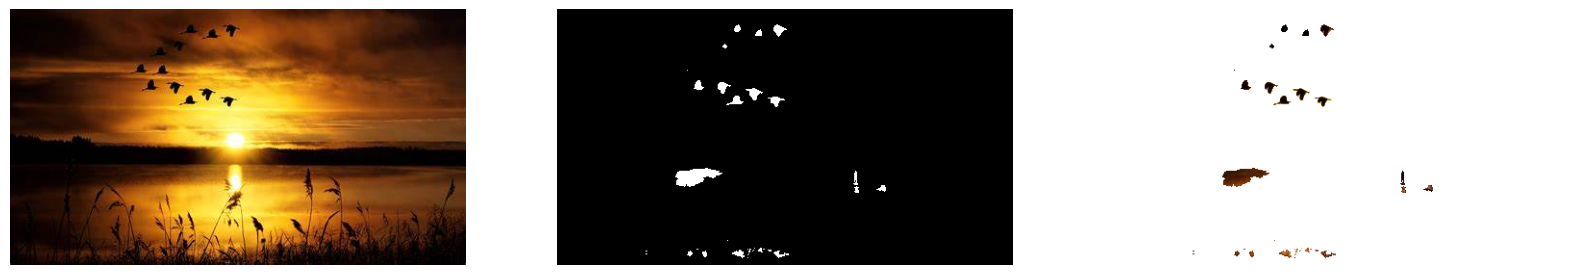

In [12]:
# Resize the network result to the image shape and round the values
# to 0 (background) and 1 (foreground).
# The network result has (1,1,512,512) shape. The `np.squeeze` function converts this to (512, 512).
resized_result = np.rint(
    cv2.resize(src=np.squeeze(result), dsize=(image.shape[1], image.shape[0]))
).astype(np.uint8)

# Create a copy of the image and set all background values to 255 (white).
bg_removed_result = image.copy()
bg_removed_result[resized_result == 0] = 255

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
ax[0].imshow(image)
ax[1].imshow(resized_result, cmap="gray")
ax[2].imshow(bg_removed_result)
for a in ax:
    a.axis("off")

### Add a Background Image [$\Uparrow$](#Table-of-content:)

In the segmentation result, all foreground pixels have a value of 1, all background pixels a value of 0. Replace the background image as follows:

- Load a new `background_image`.
- Resize the image to the same size as the original image.
- In `background_image`, set all the pixels, where the resized segmentation result has a value of 1 - the foreground pixels in the original image - to 0.
- Add `bg_removed_result` from the previous step - the part of the original image that only contains foreground pixels - to `background_image`.

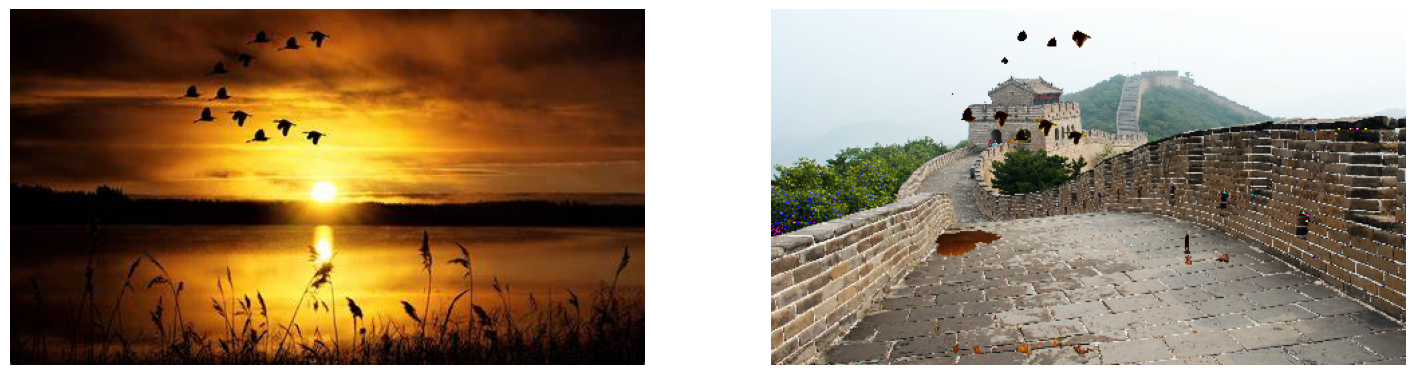

In [13]:
BACKGROUND_FILE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/wall.jpg"
OUTPUT_DIR = "output"

os.makedirs(name=OUTPUT_DIR, exist_ok=True)

background_image = cv2.cvtColor(src=load_image(BACKGROUND_FILE), code=cv2.COLOR_BGR2RGB)
background_image = cv2.resize(src=background_image, dsize=(image.shape[1], image.shape[0]))

# Set all the foreground pixels from the result to 0
# in the background image and add the image with the background removed.
background_image[resized_result == 1] = 0
new_image = background_image + bg_removed_result

# Save the generated image.
new_image_path = Path(f"{OUTPUT_DIR}/{Path(IMAGE_URI).stem}-{Path(BACKGROUND_FILE).stem}.jpg")
cv2.imwrite(filename=str(new_image_path), img=cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR))

# Display the original image and the image with the new background side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
ax[0].imshow(image)
ax[1].imshow(new_image)
for a in ax:
    a.axis("off")
plt.show()

# Create a link to download the image.
image_link = FileLink(new_image_path)
image_link.html_link_str = "<a href='%s' download>%s</a>"
display(
    HTML(
        f"The generated image <code>{new_image_path.name}</code> is saved in "
        f"the directory <code>{new_image_path.parent}</code>. You can also "
        "download the image by clicking on this link: "
        f"{image_link._repr_html_()}"
    )
)

## References [$\Uparrow$](#Table-of-content:)

* [PIP install openvino-dev](https://github.com/openvinotoolkit/openvino/blob/releases/2021/3/docs/install_guides/pypi-openvino-dev.md)
* [Model Conversion API](https://docs.openvino.ai/2023.0/openvino_docs_model_processing_introduction.html)
* [U^2-Net](https://github.com/xuebinqin/U-2-Net)
* U^2-Net research paper: [U^2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/pdf/2005.09007.pdf)